Final Project Python Code

In [1]:
import os
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from d2l import torch as d2l
from pathlib import Path
from torchmetrics.classification import BinaryF1Score
import sys

In [2]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False,strides=1):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)

        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if(self.conv3):
            X = self.conv3(X)

        Y += X
        return F.relu(Y)

In [3]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))

    return blk

In [4]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

In [5]:
def evaluate_accuracy(net, dataIter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device

        metric = d2l.Accumulator(2)

        with torch.no_grad():
            for X, y in dataIter:
                if isinstance(X, list):
                    X = [x.to(device) for x in X]
                else:
                    X = X.to(device)

                y = y.to(device)
                metric.add(d2l.accuracy(torch.round(torch.clamp(net(X), min=0, max=1)).squeeze(1), y), y.numel())
        return metric[0] / metric[1]

In [6]:
def evaluate_f1(net, dataIter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device

        evalMetric = BinaryF1Score().to(device)
        numBatches = len(dataIter)

        metric = d2l.Accumulator(2)

        with torch.no_grad():
            for X, y in dataIter:
                if isinstance(X, list):
                    X = [x.to(device) for x in X]
                else:
                    X = X.to(device)

                y = y.to(device)
                metric.add(evalMetric(net(X).squeeze(1), y), y.numel())
        return metric[0] / numBatches

In [7]:
def train(net: nn.Sequential, trainIter, testIter, numEpochs, learnRate, device: torch.device, lossFunc = nn.CrossEntropyLoss()):
    net.apply(init_weights)

    print("training on", device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=learnRate)
    animator = d2l.Animator(xlabel="Epoch", xlim=[0, numEpochs], legend=["train loss", "train acc", "test acc", "train f1"])
    timer, num_batches = d2l.Timer(), len(trainIter)

    evalMetric = BinaryF1Score().to(device)

    testAcc = evaluate_accuracy(net, testIter)
    animator.add(0, (None, None, testAcc, None))

    for epoch in range(numEpochs):
        metric = d2l.Accumulator(4)
        net.train()
        for i, (X, y) in enumerate(trainIter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            yhat = net(X)
            
            realYHat = torch.round(torch.clamp(yhat, min=0, max=1).squeeze(1))
            realY = y.float()

            l = lossFunc(yhat.squeeze(1), realY)
            l.backward()
            optimizer.step()

            with torch.no_grad():
                metric.add(l, d2l.accuracy(realYHat, realY), X.shape[0], evalMetric(yhat.squeeze(1), realY))

            timer.stop()
            trainL = metric[0] / metric[2]
            trainAcc = metric[1] / metric[2]

            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (trainL, trainAcc, None, metric[3] / i))

        testAcc = evaluate_accuracy(net, testIter, device)
        testF1 = evaluate_f1(net, testIter, device)
        animator.add(epoch + 1, (None, None, testAcc))

    print(f"loss {trainL:.3f}, train acc {trainAcc:.3f}, test acc {testAcc:.3f}, train f1 score: {metric[3] / num_batches:.3f}, test f1 score: {testF1:.3f}")
    print(f"{metric[2] * numEpochs / timer.sum():.1f} examples/sec on {str(device)}")

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")

sideLength = 256
batchSize = 10
numEpochs = 5
learnRate = 0.008


block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
block2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
block3 = nn.Sequential(*resnet_block(64, 128, 2))
block4 = nn.Sequential(*resnet_block(128, 256, 2))
block5 = nn.Sequential(*resnet_block(256, 512, 2))
net = nn.Sequential(block1, block2, block3, block4, block5, nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(512, 1))

normalize = torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])

trainAugs = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(sideLength), torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.ToTensor(), normalize])
testAugs = torchvision.transforms.Compose([torchvision.transforms.Resize(sideLength), torchvision.transforms.CenterCrop(sideLength), torchvision.transforms.ToTensor(), normalize])

trainImgs = torchvision.datasets.ImageFolder(os.path.join(sys.path[0], "train/"), transform=trainAugs)
testImgs = torchvision.datasets.ImageFolder(os.path.join(sys.path[0], "test/"), transform=testAugs)

trainIter = DataLoader(trainImgs, batch_size=batchSize, shuffle=True)
testIter = DataLoader(testImgs, batch_size=batchSize)

loss 0.598, train acc 0.730, test acc 0.769, train f1 score: 0.528, test f1 score: 0.383
280.2 examples/sec on cuda


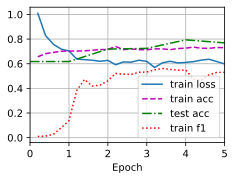

In [9]:
train(net, trainIter, testIter, numEpochs, learnRate, device)

loss 0.665, train acc 0.616, test acc 0.631, train f1 score: 0.481, test f1 score: 0.388
453.7 examples/sec on cuda


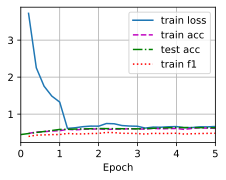

In [10]:
linearEpochs = 5
linearLR = 0.0001

linearNet = nn.Sequential(nn.Flatten(), nn.Linear(sideLength * sideLength * 3, 512), nn.Linear(512, 256), nn.Linear(256, 128), nn.Linear(128, 64), nn.Linear(64, 1))
train(linearNet, trainIter, testIter, linearEpochs, linearLR, device)

loss 0.606, train acc 0.723, test acc 0.730, train f1 score: 0.586, test f1 score: 0.364
397.5 examples/sec on cuda


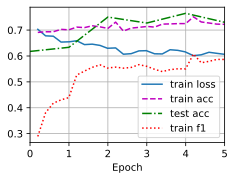

In [11]:
alexLR = 0.001

alexNet = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    
    nn.Linear(9216, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    
    nn.Linear(4096, 1))

train(alexNet, trainIter, testIter, numEpochs, alexLR, device)